# INF-510, v0.3, Claudio Torres, ctorres@inf.utfsm.cl. DI-UTFSM
## Textbook: Lloyd N. Trefethen, Spectral Methods in MATLAB, SIAM, Philadelphia, 2000

# More on Spectral Matrices

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy.sparse.linalg as sp
from scipy import interpolate
import scipy as spf
from sympy import *
import sympy as sym
from scipy.linalg import toeplitz
from ipywidgets import interact
from ipywidgets import IntSlider
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
# The variable M is used for changing the default size of the figures
M=5
import ipywidgets as widgets
import matplotlib as mpl
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

sym.init_printing()

### Chebyshev differentiation matrix

In [2]:
def cheb(N):
    if N==0:
        D=0
        x=1
        return D,x
    x = np.cos(np.pi*np.arange(N+1)/N)
    c=np.hstack((2,np.ones(N-1),2))*((-1.)**np.arange(N+1))
    X=np.tile(x,(N+1,1)).T
    dX=X-X.T
    D = np.outer(c,1./c)/(dX+np.eye(N+1))
    D = D - np.diag(np.sum(D.T,axis=0))
    return D,x

## Understanding how the np.FFT does the FFT

In [3]:
def show_spectral_derivative_example(N):
    x=np.linspace(2*np.pi/N,2*np.pi,N)
    u = lambda x: np.sin(x)
    up = lambda x: np.cos(x)
    
    #u = lambda x: np.sin(x)*np.cos(x)
    #up = lambda x: np.cos(x)*np.cos(x)-np.sin(x)*np.sin(x)
    
    v=u(x)
    K=np.fft.fftfreq(N)*N
    iK=1j*K
    vhat=np.fft.fft(v)
    
    W=iK*vhat
    W[int(N/2)]=0

    vp=np.real(np.fft.ifft(W))

    plt.figure(figsize=(10,10))
    plt.plot(x,v,'ks-',markersize=12,markeredgewidth=3,label='$\sin(x)$',linewidth=3)
    plt.plot(x,up(x),'b.-',markersize=24,markeredgewidth=3,label='Exact derivative: $\cos(x)$',linewidth=3)
    plt.plot(x,np.real(vp),'rx-',markersize=10,markeredgewidth=3,label='spectral derivative',linewidth=3)
    plt.grid(True)
    plt.legend(loc='best')
    plt.xlabel('$x$')
    plt.show()
    print('v    :',v)
    print('vhat :',vhat)
    print('K    :',K)
    print('W    :',W)
    print('vprime: ',vp)
widgets.interact(show_spectral_derivative_example,N=(2,40,2))

A Jupyter Widget

<function __main__.show_spectral_derivative_example>

In [4]:
def spectralDerivativeByFFT(v,nu=1):
    if not np.all(np.isreal(v)):
        raise ValueError('The input vector must be real')
    N=v.shape[0]
    K=np.fft.fftfreq(N)*N
    iK=(1j*K)**nu
    v_hat=np.fft.fft(v)
    w_hat=iK*v_hat
    if np.mod(nu,2)!=0:
        w_hat[int(N/2)]=0
    return np.real(np.fft.ifft(w_hat))

def my_D2_spec_2pi(N):
    h=(2*np.pi/N)
    c=np.zeros(N)
    j=np.arange(1,N)
    c[0]=-np.pi**2/(3.*h**2)-1./6.
    c[1:]=-0.5*((-1)**j)/(np.sin(j*h/2.)**2)
    D2=toeplitz(c)
    return D2

# Example 1: Computing Eigenvalues

We are solving: $-u''(x)+x^2\,u(x)=\lambda\, u(x)$ on $\mathbb{R}$

In [5]:
L=8.0
def show_example_1(N=6):
    h=2*np.pi/N
    x=np.linspace(h,2*np.pi,N)
    x=L*(x-np.pi)/np.pi
    D2=(np.pi/L)**2*my_D2_spec_2pi(N)
    w, v = np.linalg.eig(-D2+np.diag(x**2))
    # eigenvalues = np.sort(np.linalg.eigvals(-D2+np.diag(x**2)))
    ii = np.argsort(w)
    w=w[ii]
    v=v[:,ii]
    
    plt.figure(figsize=(2*M,2*M))

    for i in np.arange(1,5):
        plt.subplot(2,2,i)
        plt.title(r'$u_{:d}(x),\, \lambda_{:d}={:f}$'.format(i,i,w[i-1]))
        plt.plot(x,v[:,i],'kx',markersize=16,markeredgewidth=3)
        plt.grid(True)
    plt.show()
widgets.interact(show_example_1,N=(6,100,1))

A Jupyter Widget

<function __main__.show_example_1>

# Example 2:  Solving ODE

Solving the following BVP $u_{xx}=\exp(4\,x)$ with $u(-1)=u(1)=0$

In [6]:
def example_2(N=16):
    D,x = cheb(N)
    D2  = np.dot(D,D)
    D2  = D2[1:-1,1:-1]
    f   = np.exp(4*x[1:-1])
    u   = np.linalg.solve(D2,f)
    u   = np.concatenate(([0],u,[0]),axis=0)

    plt.figure(figsize=(M,M))
    plt.plot(x,u,'k.')
    xx  = np.linspace(-1,1,1000)
    P   = np.polyfit(x, u, N)
    uu  = np.polyval(P, xx)
    plt.plot(xx,uu,'b-')
    plt.grid(True)
    exact = (np.exp(4*xx)-np.sinh(4.)*xx-np.cosh(4.))/16.
    plt.title('max error= '+str(np.linalg.norm(exact-uu,np.inf)))
    plt.ylim([-2.5,0.5])
    plt.show()
interact(example_2,N=(2,35))

A Jupyter Widget

<function __main__.example_2>

# Example 3: Solving ODE 

Solving the following BVP $u_{xx}=\exp(u)$ with $u(-1)=u(1)=0$

In [7]:
def example_3(N=16,IT=20):
    D,x = cheb(N)
    D2  = np.dot(D,D)
    D2  = D2[1:-1,1:-1]

    u   = np.zeros(N-1)
    for i in np.arange(IT):
        u_new = np.linalg.solve(D2,np.exp(u))
        change = np.linalg.norm(u_new-u,np.inf)
        u = u_new

    u = np.concatenate(([0],u,[0]),axis=0)

    plt.figure(figsize=(M,M))
    plt.plot(x,u,'k.')
    xx  = np.linspace(-1,1,1000)
    P   = np.polyfit(x, u, N)
    uu  = np.polyval(P, xx)
    plt.plot(xx,uu,'b-')
    plt.grid(True)
    plt.title('IT= '+str(IT)+' u(0)= '+str(u[int(N/2)]))
    plt.ylim([-0.5,0.])
    plt.show()

interact(example_3,N=(2,30),IT=(0,100))

A Jupyter Widget

<function __main__.example_3>

# Example 4: Eigenvalue BVP

Solve $u_{xx}=\lambda\,u$ with $u(-1)=u(1)=0$

In [8]:
N_widget = IntSlider(min=2, max=50, step=1, value=10)
j_widget = IntSlider(min=1, max=49, step=1, value=5)

def update_j_range(*args):
    j_widget.max = N_widget.value-1
j_widget.observe(update_j_range, 'value')

def example_4(N=36,j=5):
    D,x = cheb(N)
    D2  = np.dot(D,D)
    D2  = D2[1:-1,1:-1]

    lam, V = np.linalg.eig(D2)

    ii=np.argsort(-np.real(lam))

    lam=lam[ii]
    V=V[:,ii]

    u = np.concatenate(([0],V[:,j-1],[0]),axis=0)

    plt.figure(figsize=(2*M,M))
    plt.plot(x,u,'k.')
    xx  = np.linspace(-1,1,1000)
    P   = np.polyfit(x, u, N)
    uu  = np.polyval(P, xx)
    plt.plot(xx,uu,'b-')
    plt.grid(True)
    plt.title('eig '+str(j)+' = '+str(lam[j-1]*4./(np.pi**2))+' pi**2/4'+'     ppw '+str(4*N/(np.pi*j)))
    plt.show()
interact(example_4,N=N_widget,j=j_widget)

A Jupyter Widget

<function __main__.example_4>

# Example 5:  (2D) Poisson equation $u_{xx}+u_{yy}=f$ with u=0 on $\partial\Gamma$

In [9]:
elev_widget = IntSlider(min=0, max=180, step=10, value=40)
azim_widget = IntSlider(min=0, max=360, step=10, value=230)

def example_5(N=10,elev=40,azim=230):
    D,x = cheb(N)
    y=x
    D2  = np.dot(D,D)
    D2  = D2[1:-1,1:-1]

    xx,yy=np.meshgrid(x[1:-1],y[1:-1])
    xx = xx.flatten()
    yy = yy.flatten()

    f = 10*np.sin(8*xx*(yy-1))

    I = np.eye(N-1)
    # The Laplacian
    L = np.kron(I,D2)+np.kron(D2,I)

    u = np.linalg.solve(L,f)

    fig = plt.figure(figsize=(2*M,2*M))

    # The spy of the Laplacian
    plt.subplot(221)
    plt.spy(L)

    # Plotting the approximation and its interpolation

    # The numerical approximation
    uu = np.zeros((N+1,N+1))
    uu[1:-1,1:-1]=np.reshape(u,(N-1,N-1))
    xx,yy=np.meshgrid(x,y)
    value = uu[int(N/4),int(N/4)]

    plt.subplot(222,projection='3d')
    ax = fig.gca()
    #surf = ax.plot_surface(xxx, yyy, uuu_n, rstride=1, cstride=1, cmap=cm.coolwarm,
    #                       linewidth=0, antialiased=False)
    ax.plot_wireframe(xx, yy, uu)
    ax.view_init(elev,azim)

    # The INTERPOLATED approximation

    N_fine=4*N
    finer_mesh=np.linspace(-1,1,N_fine)
    xxx,yyy=np.meshgrid(finer_mesh,finer_mesh)
    uuu = spf.interpolate.interp2d(xx, yy, uu, kind='linear')
    uuu_n=np.reshape(uuu(finer_mesh,finer_mesh),(N_fine,N_fine))

    plt.subplot(224,projection='3d')
    ax = fig.gca()
    surf = ax.plot_surface(xxx, yyy, uuu_n, rstride=1, cstride=1, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    #ax.plot_wireframe(xxx, yyy, uuu_n)
    fig.colorbar(surf)
    ax.view_init(elev,azim)
    
    plt.subplot(223)
    ax = fig.gca()
    #surf = ax.plot_surface(xxx, yyy, uuu_n, rstride=1, cstride=1, cmap=cm.coolwarm,
    #                       linewidth=0, antialiased=False)
    extent = [x[0], x[-1], y[0], y[-1]]
    plt.imshow(uu, extent=extent)
    plt.ylabel('$y$')
    plt.xlabel('$x$')
    plt.colorbar()
    
    plt.show()
interact(example_5,N=(3,20),elev=elev_widget,azim=azim_widget)

A Jupyter Widget

<function __main__.example_5>

# Example 6:  (2D) Helmholtz equation $u_{xx}+u_{yy}+k^2\,u=f$ with u=0 on $\partial\Gamma$

In [10]:
elev_widget = IntSlider(min=0, max=180, step=10, value=40)
azim_widget = IntSlider(min=0, max=360, step=10, value=230)

def example_6(N=10,elev=40,azim=230,k=9,n_contours=8):
    D,x = cheb(N)
    y=x
    D2  = np.dot(D,D)
    D2  = D2[1:-1,1:-1]

    xx,yy=np.meshgrid(x[1:-1],y[1:-1])
    xx = xx.flatten()
    yy = yy.flatten()

    f = np.exp(-10.*((yy-1.)**2+(xx-.5)**2))

    I = np.eye(N-1)
    # The Laplacian
    L = np.kron(I,D2)+np.kron(D2,I)+k**2*np.eye((N-1)**2)

    u = np.linalg.solve(L,f)

    fig = plt.figure(figsize=(2*M,2*M))

    # Plotting the approximation and its interpolation

    # The numerical approximation
    uu = np.zeros((N+1,N+1))
    uu[1:-1,1:-1]=np.reshape(u,(N-1,N-1))
    xx,yy=np.meshgrid(x,y)
    value = uu[int(N/4),int(N/4)]

    plt.subplot(221,projection='3d')
    ax = fig.gca()
    #surf = ax.plot_surface(xxx, yyy, uuu_n, rstride=1, cstride=1, cmap=cm.coolwarm,
    #                       linewidth=0, antialiased=False)
    ax.plot_wireframe(xx, yy, uu)
    ax.view_init(elev,azim)

    plt.subplot(222)
    plt.contour(xx, yy, uu, n_contours,
                 colors='k',  # negative contours will be dashed by default
                 )
   
    # The INTERPOLATED approximation
    N_fine=4*N
    finer_mesh=np.linspace(-1,1,N_fine)
    xxx,yyy=np.meshgrid(finer_mesh,finer_mesh)
    uuu = spf.interpolate.interp2d(xx, yy, uu, kind='linear')
    uuu_n=np.reshape(uuu(finer_mesh,finer_mesh),(N_fine,N_fine))

    plt.subplot(223,projection='3d')
    ax = fig.gca()
    #surf = ax.plot_surface(xxx, yyy, uuu_n, rstride=1, cstride=1, cmap=cm.coolwarm,
    #                       linewidth=0, antialiased=False)
    ax.plot_wireframe(xxx, yyy, uuu_n)
    ax.view_init(elev,azim)
    
    plt.subplot(224)
    plt.contour(xxx, yyy, uuu_n, n_contours,
                 colors='k',  # negative contours will be dashed by default
                 )
    
    plt.show()
interact(example_6,N=(3,30),elev=elev_widget,azim=azim_widget,k=(1,20),n_contours=(5,12))

A Jupyter Widget

<function __main__.example_6>

# Example 7:  (2D)  $-(u_{xx}+u_{yy})=\lambda\,u$ with u=0 on $\partial\Gamma$

In [11]:
elev_widget = IntSlider(min=0, max=180, step=10, value=40)
azim_widget = IntSlider(min=0, max=360, step=10, value=230)
N_widget = IntSlider(min=2, max=30, step=1, value=10)
j_widget = IntSlider(min=1, max=20, step=1, value=1)

def update_j_range(*args):
    j_widget.max = (N_widget.value-1)**2
j_widget.observe(update_j_range, 'value')

def example_7(N=10,elev=40,azim=230,n_contours=8,j=1):
    D,x = cheb(N)
    y=x
    D2  = np.dot(D,D)
    D2  = D2[1:-1,1:-1]

    xx,yy=np.meshgrid(x[1:-1],y[1:-1])
    xx = xx.flatten()
    yy = yy.flatten()

    I = np.eye(N-1)
    # The Laplacian
    L = (np.kron(I,-D2)+np.kron(-D2,I))

    lam, V = np.linalg.eig(L)

    ii=np.argsort(np.real(lam))
    lam=lam[ii]
    V=V[:,ii]

    fig = plt.figure(figsize=(2*M,M))

    # Plotting the approximation and its interpolation

    # The numerical approximation
    vv = np.zeros((N+1,N+1))
    vv[1:-1,1:-1]=np.reshape(np.real(V[:,j-1]),(N-1,N-1))
    xx,yy=np.meshgrid(x,y)

    plt.subplot(221,projection='3d')
    ax = fig.gca()
    #surf = ax.plot_surface(xxx, yyy, uuu_n, rstride=1, cstride=1, cmap=cm.coolwarm,
    #                       linewidth=0, antialiased=False)
    ax.plot_wireframe(xx, yy, vv)
    plt.title('eig '+str(j)+'/ (pi/2)**2= '+str(lam[j-1]/((np.pi/2)**2)))
    ax.view_init(elev,azim)

    plt.subplot(222)
    plt.contour(xx, yy, vv, n_contours,
                 colors='k',  # negative contours will be dashed by default
                 )

    # The INTERPOLATED approximation
    N_fine=4*N
    finer_mesh=np.linspace(-1,1,N_fine)
    xxx,yyy=np.meshgrid(finer_mesh,finer_mesh)
    vvv = spf.interpolate.interp2d(xx, yy, vv, kind='linear')
    vvv_n=np.reshape(vvv(finer_mesh,finer_mesh),(N_fine,N_fine))

    plt.subplot(223,projection='3d')
    ax = fig.gca()
    #surf = ax.plot_surface(xxx, yyy, uuu_n, rstride=1, cstride=1, cmap=cm.coolwarm,
    #                       linewidth=0, antialiased=False)
    ax.plot_wireframe(xxx, yyy, vvv_n)
    ax.view_init(elev,azim)

    plt.subplot(224)
    plt.contour(xxx, yyy, vvv_n, n_contours,
                 colors='k',  # negative contours will be dashed by default
                 )

    plt.show()
interact(example_7,N=N_widget,elev=elev_widget,azim=azim_widget,n_contours=(5,12),j=j_widget)

A Jupyter Widget

<function __main__.example_7>

# In-class work

## [Flash back] Implement Program 6, 7 and 12.

$ u_t + c(x) u_x = 0$

In [12]:
def my_D_spec(N):
    h=(2./N)*np.pi
    c=np.zeros(N)
    j=np.arange(1,N)
    c[1:]=0.5*((-1)**j)*(np.tan(j*h/2.)**(-1))
    r=np.zeros(N)
    r[0]=c[0]
    r[1:]=c[-1:0:-1]
    D=np.pi*toeplitz(c,r=r)
    return D

# This is almost the same as the previous notebook but with a 2*np.pi coefficient removed (Why?!).
def my_D_spec_2pi(N):
    h=(2./N)*np.pi
    c=np.zeros(N)
    j=np.arange(1,N)
    c[1:]=0.5*((-1)**j)*(np.tan(j*h/2.)**(-1))
    r=np.zeros(N)
    r[0]=c[0]
    r[1:]=c[-1:0:-1]
    D=toeplitz(c,r=r)
    return D

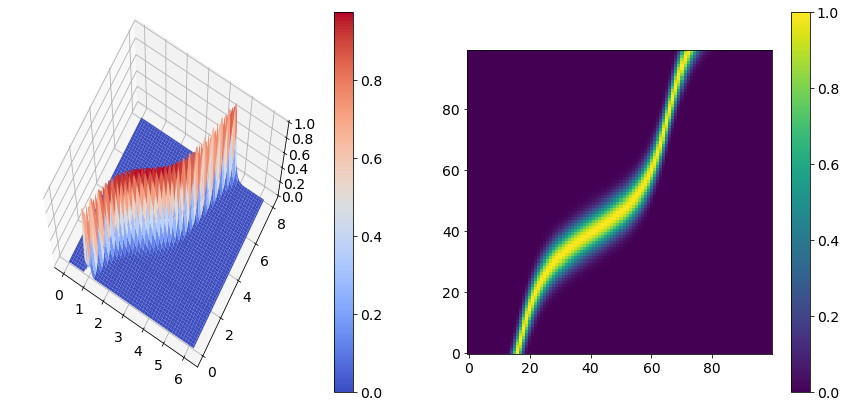

In [13]:
#Program 6
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
#Grid variable
T_max = 8
N = 100
h = 2*np.pi / N
x = h * np.arange(N)

c = .2 +np.sin(x-1)**2

v_0 = np.exp(-100*(x-1)**2)
D = my_D_spec_2pi(N)

c_D = np.dot(-np.diag(c),D)

t = np.linspace(0,8,100)

f = lambda v,t: np.dot(c_D, v)
w = spf.integrate.odeint(f, v_0, t)


xx,tt = np.meshgrid(x,t)

fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(121,projection='3d')
ax.view_init(70)
surf = ax.plot_surface(xx,tt,w, cmap=cm.coolwarm)
fig.colorbar(surf)

ax = fig.add_subplot(122)
img = ax.imshow(w, origin="lower")
fig.colorbar(img)
plt.show()
#plt.imshow(w,origin="lower")
#plt.colorbar()

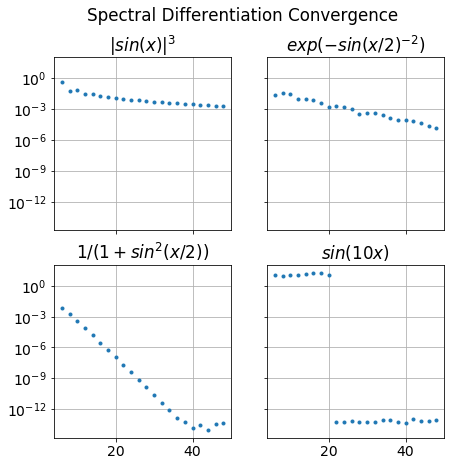

In [14]:
#Program 7
Nmax = 50
functions = [lambda x: np.abs(np.sin(x))**3,
             lambda x: np.exp(- np.sin(x/2.)**-2), 
             lambda x: 1/(1+ np.sin(x/2.)**2),
             lambda x: np.sin(10*x)
            ]
dfunctions = [
             lambda x: 3*np.sin(x)*np.cos(x)*np.abs(np.sin(x)),
             lambda x: 0.5*np.exp(- np.sin(x/2.)**-2)*np.sin(x) / np.sin(x/2.)**4,
             lambda x: -np.sin(x/2.)*np.cos(x/2.)/(1+ np.sin(x/2.)**2)**2,
             lambda x: 10*np.cos(10*x)
            ]
E = np.zeros((len(functions),Nmax//2-3))
for i,(f, df) in enumerate(zip(functions,dfunctions)):
    for j,N in enumerate(np.arange(6,Nmax,2)):
        D = my_D_spec_2pi(N)
        x = np.linspace(0,2*np.pi,N+1)[1:]
        v = f(x)
        v_prime = df(x)
        
        E[i,j] = np.linalg.norm(np.dot(D,v) - v_prime, np.inf)
Ns = np.arange(6,Nmax,2)

titles = [r"$|sin(x)|^3$", r"$exp(-sin(x/2)^{-2})$", r"$1/(1+sin^2(x/2))$",r"$sin(10x)$"]


fig, ax = plt.subplots(2,2, figsize=(7,7),sharey=True,sharex=True)
fig.suptitle("Spectral Differentiation Convergence")
for i,title in enumerate(titles):
    ax.flatten()[i].semilogy(Ns, E[i,:], ".")
    ax.flatten()[i].grid()
    ax.flatten()[i].set_title(title)
plt.show()

To get better results with $f(x)=|sin(x)|^3$ we need to divide the domain, we know that the function $f(x)$ is not smooth in $x = 0$, but is smooth in $[-\pi, 0]$ and $]0,\pi]$, so we can calculate the derivative in each interval.

Our Differentiation matrix $D$ is for functions in the interval $[0,2\pi]$ we need to transform this matrix to the new intervals.


$$  \underbrace{[0,2\pi]}_{\hat{x}} \rightarrow \underbrace{[a,b]}_{x}   $$

We know that 
$$ x = \frac{b-a}{2\pi}\hat{x} + a$$
and
$$ dx = \frac{b-a}{2\pi}d\hat{x} \\ \frac{d\hat{x}}{dx} = \frac{2\pi}{b-a} $$

The derivative we are looking is
$$ \frac{df}{dx} = \frac{df}{d\hat{x}} \frac{\hat{x}}{x} = \frac{2\pi}{b-a}\frac{df}{d\hat{x}}  $$

Using $a = -\pi, b = 0$
$$  \frac{df}{dx} = 2 \frac{df}{d\hat{x}}$$
To calculate $f'$ we can use the $D$ matrix and get the left side of the derivative, the same with the right part.

In [15]:
f = functions[0]
df = dfunctions[0]
Ns = np.arange(6,Nmax,2)
E = np.zeros_like(Ns)
def sin_spec(N=10):
    # Getting left side of derivative
    D = my_D_spec_2pi(N)
    x = np.linspace(-np.pi,0,N+1)[1:]
    v = f(x)
    v_prime = df(x)
    v_hat_prime = 2*np.dot(D,v)
    
    
    #Getting right side of derivative
    xx = x
    D = my_D_spec_2pi(N)
    x = np.linspace(0,np.pi,N+1)[1:]
    v = f(x)
    v_prime = np.append(v_prime,df(x))
    v_hat_prime = np.append(v_hat_prime,2*np.dot(D,v))
    
    xx= np.append(xx,x)
    plt.plot(xx, v_hat_prime,'r.')    
    plt.plot(xx, v_prime,'b.')
    
    plt.plot(xx,f(xx))
    plt.plot(xx, v_hat_prime,'r--')
    plt.plot(xx, v_prime,'b--')
    
    plt.legend([r"$\hat{v}'$", r"$v'$", r"$v$"])
    plt.show()
    
#     E[j] = np.linalg.norm(v_hat_prime - v_prime, np.inf)
    
interact(sin_spec,N=(10,30,2))

A Jupyter Widget

<function __main__.sin_spec>

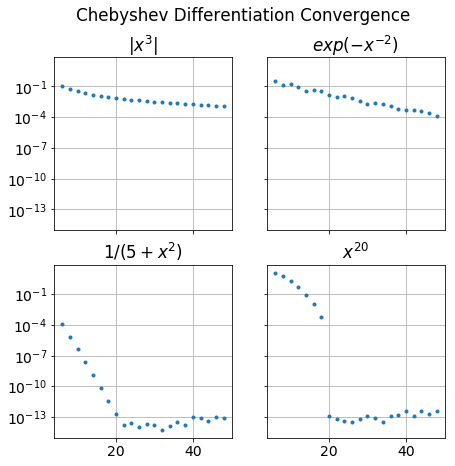

In [16]:
#Program 12
functions = [
             lambda x: np.abs(x)**3,
             lambda x: np.exp(-x**(-2)),
             lambda x: 1/(5+x**2),
             lambda x: x**20
            ]
dfunctions= [
             lambda x: 3*x*np.abs(x),
             lambda x: 2 * functions[1](x)/x**3,
             lambda x: -2*x*functions[2](x)**2,
             lambda x: 20*x**19
            ]

E = np.zeros((len(functions),Nmax//2-3))
for i,(f, df) in enumerate(zip(functions,dfunctions)):
    for j,N in enumerate(np.arange(6,Nmax,2)):
        D,x = cheb(N)
        v = f(x)
        v_prime = df(x)
        E[i,j] = np.linalg.norm(np.dot(D,v) - v_prime)
    
titles = [r"$|x^3|$", r"$exp(-x^{-2})$", r"$1/(5+x^2)$",r"$x^{20}$"]
Ns = np.arange(6,Nmax,2)    

fig, ax = plt.subplots(2,2, figsize=(7,7),sharey=True,sharex=True)
fig.suptitle("Chebyshev Differentiation Convergence")
for i,title in enumerate(titles):
    ax_i = ax.flatten()[i]
    ax_i.semilogy(Ns, E[i,:], ".")
    ax_i.grid()
    ax_i.set_title(title)
plt.show()

## [Today] Implement Program 19, 20, 21, 22 and 23.

In [17]:
#Program 18
def chebfft(v):
    N = len(v)
    x = np.cos(np.arange(N)*np.pi/(N-1))
    
    V = np.append(v,np.flip(v[1:-1],axis=0))
    U = np.fft.fft(V).real

    ii = np.append(np.arange(N-1),0)
    ii = np.append(ii,np.arange(1-(N-1),0))

    W_k = 1j* ii * U

    W_j = np.fft.ifft(W_k).real
    w = np.zeros_like(v)
    w[1:-1] = -W_j[1:N-1] / np.sqrt(1-x[1:-1]**2)

    ii = np.arange(N-1)
    
    w[0] = np.sum(ii**2 * U[ii])/(N-1) + 0.5 * (N-1) * U[N-1]
    w[N-1] = np.sum((-1)**(ii+1) * (ii**2) * U[ii])/(N-1) + 0.5 * (-1)**(N) * (N-1) * U[N-1]
    
    return w



def chebfft_diff(N=10):
    xx = np.linspace(-1,1,100)
    ff=np.exp(xx) * np.sin(5*xx)
    
    x = np.cos(np.pi*np.arange(N+1)/N);f=np.exp(x)* np.sin(5*x)
    
    error = chebfft(f) - np.exp(x) * (np.sin(5*x) + 5*np.cos(5*x))
    
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7),sharex=True)

    ax1.plot(x, chebfft(f), "r")
    v_hat = np.exp(x) * (np.sin(5*x) + 5*np.cos(5*x))
    ax1.plot(x, v_hat ,"b--")
    ax1.plot(xx,ff)
    ax1.legend([r"$df'(x)$",r"$\hat{df}(x)$"])
    ax1.grid()
    
    ax2.plot(x,error)
    ax2.plot(x,error,'.')
    ax2.set_title("Error avg:{0:.3e}".format(np.abs(error).mean()))
    ax2.grid()
    plt.show()
    #print(error)
    
interact(chebfft_diff,N=(10,100,2))

A Jupyter Widget

<function __main__.chebfft_diff>

$u_{tt} = u_{xx}$, $-1 < x < 1$, $t > 0$, $u(\pm 1) = 0$ 

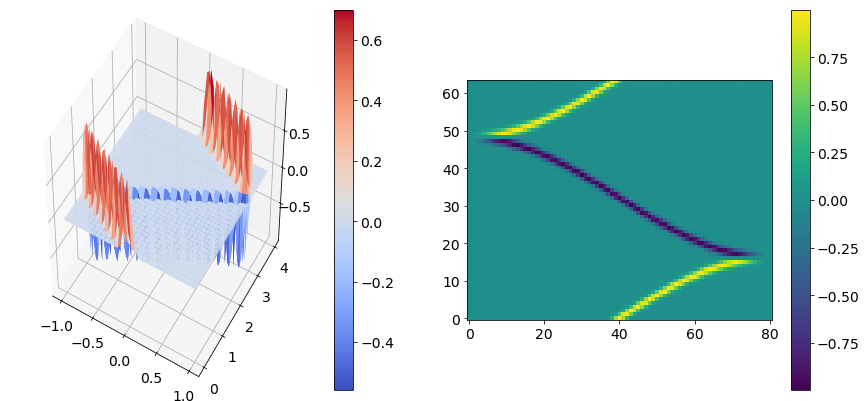

In [18]:
#Program 19
tmax= 4
plot_iter = 50

N = 80; x = np.cos(np.arange(N+1)*np.pi/N);dt = 8/N**2;
v = np.exp(-200*x**2); vold = np.exp(-200*(x-dt)**2)

ts = np.arange(0,tmax,dt)
tplot = []
E = np.empty((N+1,len(ts)//plot_iter))

#Leapfrog formula
for i,t in enumerate(ts):
    w = chebfft(chebfft(v))
    w[0]  = 0
    w[-1] = 0
    
    vnew = 2*v - vold + dt**2 * w
    vold = v
    v = vnew
    if i%plot_iter == 0:
        E[:,i//plot_iter] = v
        tplot.append(t)

        
#Plotting
xx,tt = np.meshgrid(x,tplot)

fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(121,projection='3d')
ax.view_init(45)
surf = ax.plot_surface(xx,tt,E.T, cmap=cm.coolwarm)
fig.colorbar(surf)

ax = fig.add_subplot(122)
img = ax.imshow(E.T, origin="lower")
fig.colorbar(img)
plt.show()

In [19]:
tmax= 4
plot_iter = 50
N = 80; x = np.cos(np.arange(N+1)*np.pi/N);dt = 8/N**2;
v = np.exp(-200*x**2)
v_prime = -200*2*x*np.exp(-200*x**2)
t = np.arange(0,tmax,dt)
def f(u,t):
    u = np.split(u,2)
    return np.append(chebfft(chebfft(u[1])), u[0])

w = spf.integrate.odeint(f, np.append(v,v_prime) , t)

ii = np.linspace(0,w.shape[0],N,endpoint=False).astype(np.int)
t = t[ii]
E = w[ii,:N+1]

/home/tronco/anaconda3/lib/python3.5/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


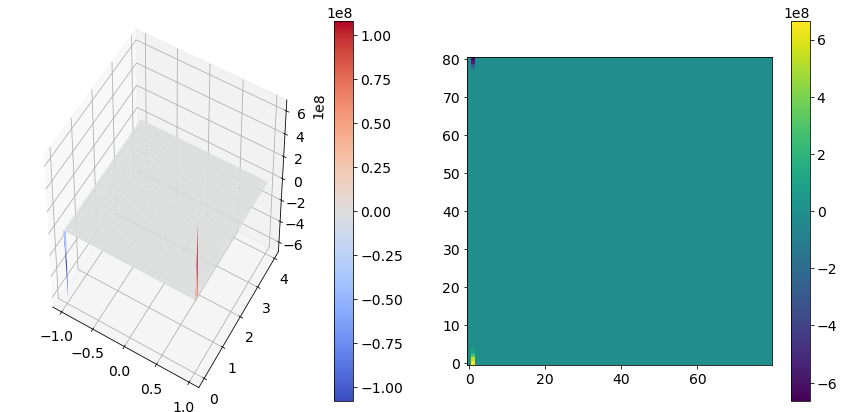

In [20]:
#Plotting
xx,tt = np.meshgrid(x,t)

fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(121,projection='3d')
ax.view_init(45)
surf = ax.plot_surface(xx,tt,E, cmap=cm.coolwarm)
fig.colorbar(surf)

ax = fig.add_subplot(122)
img = ax.imshow(E.T, origin="lower")
fig.colorbar(img)
plt.show()


In [21]:
#Program 20
T_max = 8
N = 24
x = np.cos(np.pi*np.arange(N)/N)
xx,yy=np.meshgrid(x,x)
vv = np.exp(-40*((xx-0.4)**2)+ yy**2)
vvold = vv

times = np.linspace(0,1,10)
sol = np.empty((N,N,len(times)))

In [22]:
#Program 21
# - u_xx + 2 q cos(2x) u = lambda u


def mathieu_operator(N=20):
    h = 2*np.pi/N; x = h*(np.arange(N)+1)
    D2 = my_D2_spec_2pi(N)

    qq = np.linspace(0,15,100)
    data = np.empty((11,len(qq)))
    for i,q in enumerate(qq):
        lam,vecs = np.linalg.eig(-D2 + 2*q*np.diag(np.cos(2*x)))
        e = np.sort(lam.real)
        data[:,i] = e[:11]
    fig = plt.figure(figsize=(5,10))
    for i in range(11):
        plt.plot(qq,data[i,:])
    plt.ylabel(r"$\lambda$")
    plt.xlabel(r"q")
    plt.xticks([0,5,10,15])
    plt.yticks(np.arange(-24,34,4))
    plt.grid()
    plt.show()
    
interact(mathieu_operator,N=(14,100,2))

A Jupyter Widget

<function __main__.mathieu_operator>

In [23]:
#program 22
# u_xx = x lambda  u
import scipy.linalg as sla
from scipy.special import airy

def airy_equation(N=10):
    D,x = cheb(N)
    D2 = np.dot(D,D)
    D2 = D2[1:-1,1:-1]
    vals,vecs=sla.eig(a=D2,b=np.diag(x[1:-1]))
    
    vals_pos = vals[vals > 0].real
    vecs_pos = vecs[:,vals > 0].real
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,5))
    ax1.plot(vals_pos[:11])
    ax1.plot(vals_pos[:11],'.')
    ax1.set_title("Eigenvalues")
    
    
    ii = vals_pos.argsort()
    i = ii[4]
    v = np.append(0,vecs_pos[:,i])
    v = np.append(v,0)
    v = v/v[N//2] * airy(0)[0]   
    
    ax2.plot(x,v)
    ax2.set_title(r"5-th eigvector $\lambda$: {}".format(vals_pos[i]))
    ax2.set_ylim([-1,1])
    plt.show()
    
    
    #plt.plot(vecs[5].real)
    #plt.title(r"$\lambda$:{}".format(vals[5].real))
    #plt.show()

interact(airy_equation,N=(12,100,4))

A Jupyter Widget

<function __main__.airy_equation>

In [24]:
#program 23
def get_eigvector(i=1,n_contour=1,N=16):
    i -= 1

    if i >= N:
        i = N-1
        
    D,x = cheb(N)
    y = x

    xx,yy = np.meshgrid(x[1:-1],y[1:-1])
    xx = xx.flatten()
    yy = yy.flatten()
    D2 = np.dot(D,D)
    D2 = D2[1:-1,1:-1]
    
#     D2 = np.diag(-2*np.ones(N+1)) + np.diag(np.ones(N),1)+ np.diag(np.ones(N),-1)
#     D2 = D2[1:-1,1:-1]
#     x = np.linspace(-1,1,N+1)
#     D2 = D2 * (x[1]-x[0])**-2

    y = x
    
    I = np.eye(N-1)

    #Laplacian
    L = -(np.kron(I,D2) + np.kron(D2,I)) #+ np.diag(np.exp(20*(yy-xx-1)))


    lam, V = np.linalg.eig(L);
    ii = lam.argsort()
    i = ii[i]
    v = V[:,i]
    
    print(np.dot(V[:,0],V[:,2] ))
    
    xx,yy = np.meshgrid(x,y)
    uu = np.empty_like(xx)
    
    uu[1:-1,1:-1]=v.reshape((N-1,N-1))
    
    plt.contour(xx,yy,uu,n_contours=n_contour)
    plt.title("eig = "+str(lam[i]/np.pi**2*4)+r" $\pi^2/4$")
    plt.show()
    
interact(get_eigvector, i = (1,100), n_contour =(1,20), N=(5,20))

A Jupyter Widget

<function __main__.get_eigvector>

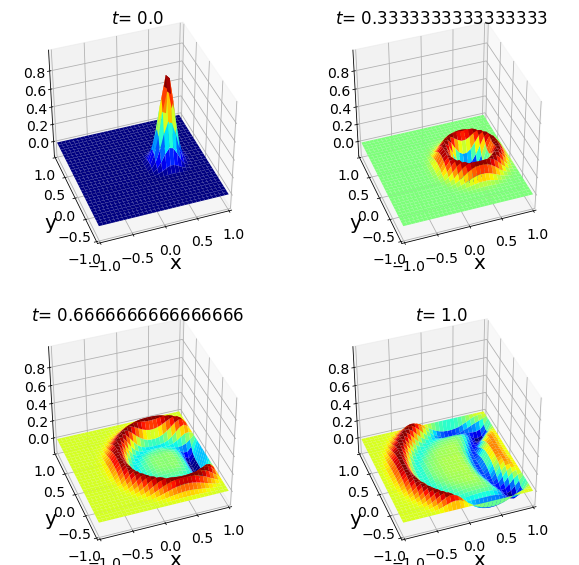

In [33]:
#http://praveen.tifrbng.res.in/teaching/chebpy

# Grid and inital Data:
N = 24; x = np.cos(np.pi*np.arange(0,N+1)/N); y = x;
t = 0.0; dt = (6.0)/(N**2)
xx, yy = np.meshgrid(x,y)
plotgap = int (round( (1.0/3.0) / (dt))); dt = (1.0/3.0)/(plotgap);            
vv = np.exp(-40*((xx-0.4)**2 + yy**2));
vvold = vv; 

#Time stepping Leapfrog Formula:
fig = plt.figure(figsize=(10,10))
k = 1;
for n in range(0,(3*plotgap)+1):
    t = n*dt;
    if (np.remainder(n+0.5,plotgap) < 1):
        ax = fig.add_subplot(2,2,k,projection ='3d')
        f = spf.interpolate.interp2d(x,y,vv,kind='cubic');
        xxx = np.arange(-1.,1.+1./16,1./16);
        vvv = f(xxx,xxx)
        X,Y = np.meshgrid(xxx,xxx);
        ax.plot_surface(X,Y,vvv,rstride=1,cstride=1,cmap=cm.jet)
        ax.set_zlim3d([-0.15,1])
        ax.set_xlim3d([-1,1])
        ax.set_ylim3d([-1,1])
        ax.view_init(elev=40., azim=250.)
        plt.title("$ t $= " +str(t))
        plt.xlabel("x"); plt.ylabel("y");
        k = k+1;
    
    uxx = np.zeros((N+1,N+1)); uyy = np.zeros((N+1,N+1));
    ii = np.arange(1,N);
    
    for i in range(1,N):
        v = vv[i,:];          
        V = list(v) + list(np.flipud(v[ii]));
        U = np.real(np.fft.fft(V));
        w1_hat = 1j*np.zeros(2*N);
        w1_hat[0:N] = 1j*np.arange(0,N)
        w1_hat[N+1:] = 1j*np.arange(-N+1,0)
        W1 = np.real(np.fft.ifft(w1_hat * U))
        w2_hat = 1j*np.zeros(2*N);
        w2_hat[0:N+1] = np.arange(0,N+1)
        w2_hat[N+1:] = np.arange(-N+1,0)
        W2 = np.real(np.fft.ifft((-w2_hat**2) * U))
        uxx[i,ii] = W2[ii]/(1-x[ii]**2) - (x[ii]*W1[ii])/(1-x[ii]**2)**(3.0/2);
    for j in range(1,N):
        v = vv[:,j]; 
        V = list(v) + list(np.flipud(v[ii]));
        U = np.real(np.fft.fft(V))
        w1_hat = 1j*np.zeros(2*N);
        w1_hat[0:N] = 1j*np.arange(0,N)
        w1_hat[N+1:] = 1j*np.arange(-N+1,0)
        W1 = np.real(np.fft.ifft(w1_hat * U))
        w2_hat = 1j*np.zeros(2*N);
        w2_hat[0:N+1] = np.arange(0,N+1)
        w2_hat[N+1:] = np.arange(-N+1,0)
        W2 = np.real(np.fft.ifft(-(w2_hat**2) * U))
        uyy[ii,j] = W2[ii]/(1-y[ii]**2) - y[ii]*W1[ii]/(1-y[ii]**2)**(3.0/2.0);
    vvnew = 2*vv - vvold + dt**2 *(uxx+uyy)
    vvold = vv ; vv = vvnew;


In [2]:
import numpy as np
np.__version__

'1.12.1'